# Explanation

For further background, consult [csnsquantile](csnsquantile) for the non-importance-weighted version of this technique.

For a real-valued discrete-time random process $X_t$ and non-negative discrete-time random process $W_t$ with $\forall t: 1 = \mathbb{E}_{t-1}\left[W_t\right]$, the code below constructs a confidence sequence for the CDF of the average historical conditional distribution, $$
\begin{aligned}
\overline{\text{CDF}}_t(v) &\doteq \frac{1}{t} \sum_{s \leq t} \mathbb{E}_{s-1}\left[W_s 1_{X_s \leq v}\right],
\end{aligned}
$$
which is simultaneously valid for all times and all values.  

A novel aspect relative to the non-importance-weighted case is whether or not the importance weights have infinite variance.  In this notebook the construction reduces to a pointwise [empirical Bernstein](https://arxiv.org/abs/1810.08240) bound, which only converges with the importance weights have finite variance.  However it is faster to compute than the [DDRM](csnsopquantile) version by about a factor of 20.

# Derivation

## Step 1: Test supermartingale for $W_t 1_{X_t \leq v}$.

This is [empirical Bernstein supermartingale](https://arxiv.org/abs/1810.08240) combined with [Adagrad](https://arxiv.org/abs/1002.4862).

For fixed $v$, let $Y_t = W_t 1_{X_t \geq v}$ be a non-negative real-valued discrete-time random process, let $\hat{Y}_t \in [0, 1]$ be a predictable sequence, and let $\lambda \in [0, 1)$ be a fixed scalar bet.  Then $$
\begin{aligned}
E_t(\lambda) &\doteq \exp\left(
\lambda \left(\sum_{s \leq t} \hat{Y}_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) 
+ \sum_{s \leq t} \log\left(1 + \lambda \left(Y_s - \hat{Y}_s\right) \right)
\right) \\
\end{aligned}
$$ is a supermartingale.  Manipulating $$
\begin{aligned}
E_t(\lambda) &\doteq \exp\left(
\lambda \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) 
- \sum_{s \leq t} \underbrace{\left( \lambda \left(Y_s - \hat{Y}_s\right) - \log\left(1 + \lambda \left(Y_s - \hat{Y}_s\right) \right) \right)}_{\doteq h\left(\lambda \left(Y_s - \hat{Y}_s\right)\right)}
\right) \\
&\geq \exp\left(
\lambda \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - h(-\lambda) \sum_{s \leq t} \left(Y_s - \hat{Y}_s\right)^2\right) & \left(\text{Fan}\right) \\
&\geq \exp\left(
\lambda \left(\sum_{s \leq t} Y_s - \mathbb{E}_{s-1}\left[Y_s\right]\right) - h(-\lambda) \left( \text{Reg}(t) + \sum_{s \leq t} \left(Y_s - Y^*_t\right)^2\right) \right) & \left(\dagger\right), 
\end{aligned}
$$ where for $(\dagger)$ we use a no-regret learner on squared loss on feasible set $[0, 1]$ with regret $\text{Reg}(t)$ to any constant in-hindsight prediction $\hat{Y}_t^* \in [0, 1]$. Since $Y_s$ is unbounded above, the loss is not Lipschitz and we can't get fast rates for squared loss (afaik), but we can run Adagrad (&ldquo;empirical Lipschitz&rdquo;). $$
\begin{aligned}
\text{Reg}(t) &= 2 \sqrt{2} \sqrt{\sum_{s \leq t} g_s^2} \\
&= 4 \sqrt{2} \sqrt{\sum_{s \leq t} (Y_s - \hat{Y}_s)^2} \\
&\leq 4 \sqrt{2} \sqrt{\text{Reg}(t) + \sum_{s \leq t} (Y_s - \hat{Y}_t^*)^2}, \\
\implies \text{Reg}(t) &\leq 16 + 4 \sqrt{2} \sqrt{8 + \sum_{s \leq t} (Y_s - \hat{Y}_t^*)^2}.
\end{aligned}
$$ Thus basically our variance process is inflated by an additive square root.

We will compete with $Y^*_t = \min\left(1, \frac{1}{t} \sum_s Y_s\right)$.

**Analytical Mixture**: Define $$
\begin{aligned}
\hat{\mu}_t &\doteq \frac{1}{t} \sum_{s \leq t} Y_s, \\
\mu_t &\doteq \frac{1}{t} \sum_{s \leq t} \mathbb{E}_{s-1}\left[Y_s\right], \\
v_t &\doteq \frac{1}{t} \left(\text{Reg}(t) + \sum_{s \leq t} \left(Y_s - \hat{Y}^*_t\right)^2 \right).
\end{aligned}
$$  Then $$
\begin{aligned}
W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \int_0^1 d\text{Beta}(\lambda; 1, b)\ \exp\left(\lambda t \left(v_t + \hat{\mu}_t - \mu_t\right)\right) \left(1 - \lambda\right)^{t v_t} \\
&= b \int_0^1 d\lambda \exp\left(\lambda t \left(v_t + \hat{\mu}_t - \mu_t\right)\right) \left(1 - \lambda\right)^{t v_t + b - 1} \\
&= \left(\frac{b}{t v_t + b}\right) \left(\frac{\Gamma(c)}{\Gamma(a) \Gamma(c-a)} \int_0^1 du \exp\left(\xi u\right) u^{a-1} (1 - u)^{c-a-1}\right)\biggr|_{\substack{a=1 \\ c=t v_t + b + 1 \\ \xi= t \left(v_t + \hat{\mu}_t - \mu_t\right)}} \\
&= \left(\frac{b}{b + t v_t}\right) {}_1F_1\left(1, t v_t + b + 1, t \left(v_t + \hat{\mu}_t - \mu_t\right)\right) \\
&= \frac{b \exp\left(t \left(v_t + \hat{\mu}_t - \mu_t \right)\right)}{\left(t \left(v_t + \hat{\mu}_t - \mu_t \right)\right)^{b+t v_t}} \Gamma\left(b + t v_t, 0, t \left(v_t + \hat{\mu}_t - \mu_t \right)\right) & \left(v_t + \hat{\mu}_t - \mu_t > 0\right) \\
\log W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \log(b) - \log(b + t v_t) + \left(\frac{t}{1 + b + t v_t}\right) \epsilon + O(\epsilon^2) \biggr|_{\epsilon=v_t + \hat{\mu_t} - \mu_t}
\end{aligned}
$$ where $\Gamma(a, z_0, z_1)$ is the [Mathematica version](https://reference.wolfram.com/language/ref/Gamma.html) and ${}_1F_1(\ldots)$ is [the Kummer confluent hypergeometric function](https://reference.wolfram.com/language/ref/Hypergeometric1F1.html) which is always real-valued.

For a lower bound we just replace $Y_t \leftarrow z - Y_t$ in the derivation resulting in the same $v_t$ and $$
\begin{aligned}
W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \left(\frac{b}{b + t v_t}\right) {}_1F_1\left(1, t v_t + b + 1, t \left(v_t + \mu_t - \hat{\mu}_t\right)\right) \\
&= \frac{b \exp\left(t \left(v_t + \mu_t - \hat{\mu}_t \right)\right)}{\left(t \left(v_t + \mu_t - \hat{\mu}_t \right)\right)^{b+t v_t}} \Gamma\left(b + t v_t, 0, t \left(v_t + \mu_t - \hat{\mu}_t \right)\right) & \left(v_t + \mu_t - \hat{\mu}_t > 0\right) \\
\log W_t(b; v_t, \hat{\mu}_t, \mu_t) &= \log(b) - \log(b + t v_t) + \left(\frac{t}{1 + b + t v_t}\right) \epsilon + O(\epsilon^2) \biggr|_{
\epsilon=v_t + \mu_t - \hat{\mu_t}}
\end{aligned}
$$

## Step 2: Use a countably infinite collection of intervals

The $n$-th intervals models $\sum_{s \leq t} \mathbb{E}_{s-1}\left[1_{X_s \leq u(n)}\right]$ via the test supermartingale.  Let $\alpha(n) \geq 0$ define a (decreasing) assignment of probability with $1 \geq \sum_{n=1}^\infty \alpha(n)$ for a union bound, e.g., $\alpha(n) = 6 / (\pi^2 n^2)$.

Although we have a countable infinite number of intervals covered with a union bound, there is no point in evaluating past the point where the bounds can improve.  Specifically, if all counts are to the left of the probe, there is no point in further refining the upper boundary.

# Code

In [1]:
class StreamingEmpBernECDF(object):
    class Frozen(object):
        def __init__(self, rawsd, tot):
            from sortedcontainers import SortedDict
            super().__init__()
        
            self.sd = SortedDict()
            
            # TODO: Kahan summation
            cumsum = [ 0, 0 ]
            for k, v in rawsd.items():
                cumsum[0] += v[0]
                cumsum[1] += v[1]
                self.sd[k] = (cumsum[0], cumsum[1])
            
            self.cumsum = (cumsum[0], cumsum[1])
            self.tot = tot

        def __call__(self, H):
            if H is None:
                return self.tot
            
            hgeindex = self.sd.bisect_right(H)
            if hgeindex != len(self.sd):
                _, Hcnt = self.sd.peekitem(hgeindex)
            else:
                Hcnt = self.cumsum
                
            return Hcnt

    def __init__(self):
        from sortedcontainers import SortedDict
        super().__init__()
        
        self.sd = SortedDict()
        self.tot = 0
        
    def addobs(self, r, w):
        from numbers import Number
        assert isinstance(r, Number), r
        assert isinstance(w, Number), w
        assert w >= 0
        
        # TODO: Kahan summation
        self.sd.setdefault(r, [0, 0])
        self.sd[r][0] += w
        self.sd[r][1] += w**2
        self.tot += 1
        
    def freeze(self):
        return self.Frozen(self.sd, self.tot)
    
def logunnormalizedgamma(k, z):
    from math import log
    from scipy.special import gammainc, loggamma
    
    try:
        rv = loggamma(k) + log(gammainc(k, z))
    except:
        rv = -z + (k - 2) * log(z) + log(k + z - 1) # + O(1/z)

    return rv

def getCSLowerBound(sumy, sumysq, t, logalpha):
    from math import log, sqrt
    from scipy.optimize import root_scalar
    
    assert 0 <= sumy
    assert 0 <= sumysq
    assert t >= 1
    assert logalpha <= 0

    b = 1
    thres = -logalpha
    var = sumysq - sumy**2 / t                # optimal empirical variance
    var += 16 + 4 * sqrt(2) * sqrt(8 + var)   # adagrad regret bound
    
    def logwealth(mu):
        tz = var + sumy - t * mu
        assert tz >= 0
        
        k = tz / (1 + b + var)
        bptv = b + var
        
        if k <= 1e-2:
            return log(b) - log(bptv) + k + (bptv / (4 + 2 * bptv)) * k**2 # + O(k^3)
        else:
            return log(b) + tz - bptv * log(tz) + logunnormalizedgamma(bptv, tz)
    
    mumin = 0
    mumax = min(1, sumy/t)
    if mumax <= mumin or logwealth(mumin) <= thres:
        return mumin
    
    if logwealth(mumax) >= thres:
        return mumax
    
    res = root_scalar(f=lambda mu: logwealth(mu) - thres, bracket=[mumin, mumax])
    assert res.converged
    return res.root

def getUnifLowerBound(probe, counts, conf):
    from math import log, floor, pi
    
    lb = 0
    
    log6opsq = log(6/pi**2)
    logconf = log(conf)
    
    t = counts(None)
    sumcprobe, _ = counts(probe)
    
    # technically depth range(1, infinity)
    # in practice we have finite numerical precision
    for depth in range(1, 100):
        # grid is (k / 2**depth) for k in [0, \ldots, (2**depth)-1]
        # even values of k are duplicates from prior grids
        # hence size of grid not already covered is 2**(depth-1)
        
        logp = log6opsq - 2 * log(depth) - (depth - 1) * log(2)
        #                 ^--- union bound over depth
        #                                   ^--- shared by 2^(depth-1) 
        
        klower = floor(2**depth * probe)
        if klower % 2 == 1:
            vlower = klower / 2**depth
            assert vlower <= probe
            sumclower, sumclowersq = counts(vlower) 
            lb = max(lb, getCSLowerBound(sumclower, sumclowersq, t, logp + logconf))
            if sumclower >= sumcprobe:
                break
            
    return lb

def getGenericUpperBound(probe, counts, conf, *, refsf, refisf):
    # CDF(X; v) = P(X <= v)
    # CDF(-X; -v) = P(-X <= -v) = P(X > v) 
    from math import inf
    minuscounts = lambda a, b: (a[0] - b[0], a[1] - b[1])
    return 1 - getUnifLowerBound(refsf(probe), lambda h: counts(None) if h is None else minuscounts(counts(inf), counts(refisf(h))), conf)

def getGenericLowerBound(probe, counts, conf, *, refcdf, refppf):
    return getUnifLowerBound(refcdf(probe), lambda h: counts(None) if h is None else counts(refppf(h)), conf)

# IID Examples
In the examples below, a time-uniform version of [DKW](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality) is shown as a baseline just to get an idea of the empirical performance of the technique.  Note DKW does not hold for general data dependent generation.

In [7]:
def plotit(data, ws, true, ref, extra=[], titles=[None]*3, files=[None]*3, compare=[], hacks=[None]*3):
    from math import sqrt, log, pi
    from scipy.interpolate import interp1d
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import numpy as np
    import time
    
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
    fmt = mticker.FuncFormatter(g)
    
    linestyle_tuple = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('dashed', 'dashed'),    # Same as '--'
        ('dashdot', 'dashdot'),  # Same as '-.'
        #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ]
    megalw = 3
    megafs = 20
    
    conf = 0.05
    
    T = len(data)    
    nxvals = 1000

    ecdfx = np.sort(data)
    ecdfy = np.arange(1, len(data)+1)/float(len(data))
    probevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=ecdfy, fp=ecdfx, left=0, right=1)
    ecdff = interp1d(x=ecdfx, y=ecdfy, fill_value=(0, 1), kind='previous', bounds_error=False)
    ecdffunc = np.array([ ecdff(v) for v in probevals ])

    exactcdfy = np.array([ true.cdf(x) for x in probevals ])
    
    plt.figure()
    plt.gcf().set_size_inches(16, 8)
    plt.plot(probevals, ecdffunc - exactcdfy, label='empirical minus exact cdf')
    
    counts = StreamingEmpBernECDF()
    for r, w in zip(data, ws):
        counts.addobs(r, w)     
    icey = counts.freeze()
    lbcdfy = np.array([ getGenericLowerBound(x, counts = icey, conf = conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
    start = time.time()
    ubcdfy = np.array([ getGenericUpperBound(x, counts = icey, conf = conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
    end = time.time()
    print(f'ubcdfy calc time: {end-start:.3g}')

    plt.plot(probevals, ubcdfy - exactcdfy, label='cdf ub minus exact')
    plt.plot(probevals, exactcdfy - lbcdfy, label='cdf exact minus lb')
    plt.title(titles[0] or 'difference between bounds and exact CDF')
    plt.legend()
    if files[0]:
        plt.savefig(files[0], bbox_inches='tight')
    
    # DKW
    logtuconf = log(conf) + log(6/pi**2) - 2*log(T)
    dkwtueps = sqrt((log(2) - logtuconf) / (2 * T))
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-deep')
    plt.plot(probevals, ubcdfy - lbcdfy, color=f'C1', label=f'{true.desc}')
    minprobevals, maxprobevals = min(probevals), max(probevals)
    for n, t in tqdm(list(enumerate(compare)), desc='compare', leave=False):
        counts = StreamingEmpBernECDF()
        for r, w in zip(t.data, ws):
            counts.addobs(r, w)  
        icey = counts.freeze()
        compecdfx = np.sort(t.data)
        compecdfy = np.arange(1, len(t.data)+1)/float(len(t.data))
        compprobevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=compecdfy, fp=compecdfx, left=0, right=1)
        complbcdfy = np.array([ getGenericLowerBound(x, counts = icey, conf = conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in compprobevals ])
        compubcdfy = np.array([ getGenericUpperBound(x, counts = icey, conf = conf / 2, refsf = ref.sf, refisf = ref.isf) for x in compprobevals ])
        plt.plot(compprobevals, compubcdfy - complbcdfy, color=f'C{n+2}', label=f'{t.desc}')
        minprobevals, maxprobevals = min(minprobevals, min(compprobevals)), max(maxprobevals, max(compprobevals))
    #plt.plot([minprobevals, maxprobevals], [2*dkwtueps]*2, color=f'C0', linestyle='dashed', label=f'Time uniform DKW')
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$U_t(v) - L_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(titles[1] or f'bound widths for $T=${fmt(T)} draws from {true.desc}', fontsize=megafs+6)
    if hacks[1]:
        hacks[1](fig, ax)
    if files[1]:
        plt.savefig(files[1], bbox_inches='tight')
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-deep')
    plt.plot(probevals, exactcdfy, label='true cdf', color=f'C0', linestyle=linestyle_tuple[0][1], linewidth=megalw)
    for n, t in tqdm(list(enumerate(extra)), desc='extra', leave=False):
        counts = StreamingEmpBernECDF()
        for r, w in zip(data[:t], ws[:t]):
            counts.addobs(r, w)
        icey = counts.freeze()
        extralbcdfy = np.array([ getGenericLowerBound(x, counts = icey, conf = conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
        extraubcdfy = np.array([ getGenericUpperBound(x, counts = icey, conf = conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
        plt.plot(probevals, extralbcdfy, label=f'$t=${fmt(t)}', color=f'C{n+2}', linestyle=linestyle_tuple[n+2][1], linewidth=megalw)
        plt.plot(probevals, extraubcdfy, label=None, color=f'C{n+2}', linestyle=linestyle_tuple[n+2][1], linewidth=megalw)
    plt.plot(probevals, lbcdfy, label=f'$t=${fmt(T)}', color=f'C1', linestyle=linestyle_tuple[1][1], linewidth=megalw)
    plt.plot(probevals, ubcdfy, label=None, color=f'C1', linestyle=linestyle_tuple[1][1], linewidth=megalw)
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$\\overline{CDF}_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(titles[2] or f'ubcdf calc time for $T=${fmt(T)} at {nxvals} evenly spaced x-values: {end-start:.3f} s', fontsize=megafs+6)
    if hacks[2]:
        hacks[2](fig, ax)
    if files[2]:
        plt.savefig(files[2], bbox_inches='tight')

### Beta(6,3) reward distribution, Exp(1) weight distribution
Using the uniform$([0,1])$ distribution as reference (reward) measure.  The importance weights are unbounded but finite variance.

ubcdfy calc time: 1.01


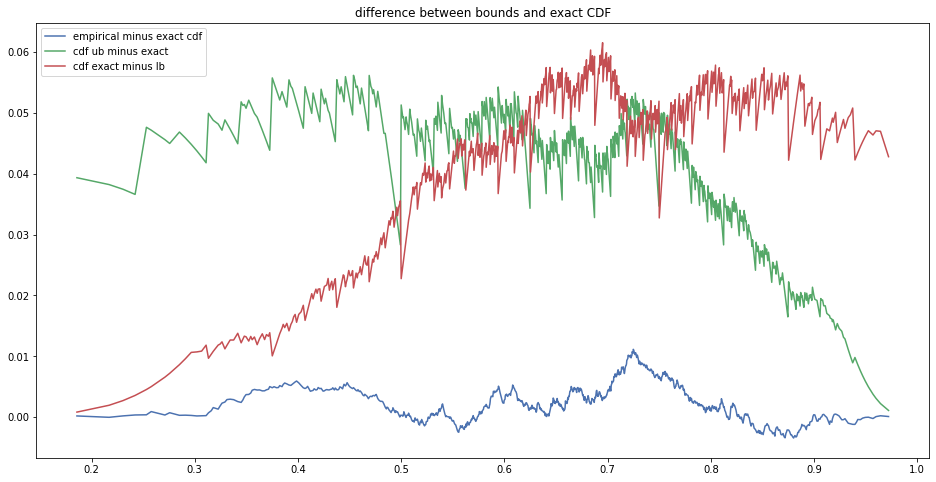

<Figure size 432x288 with 0 Axes>

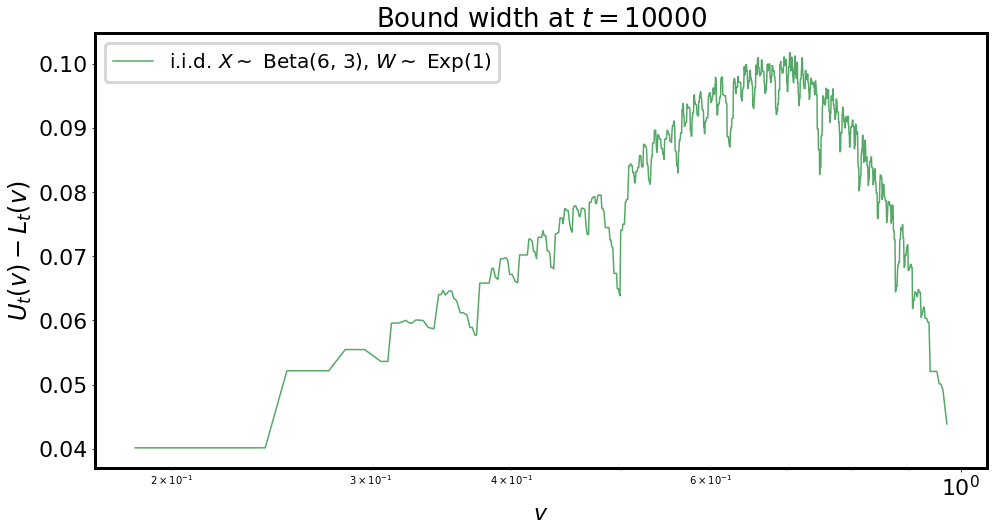

<Figure size 432x288 with 0 Axes>

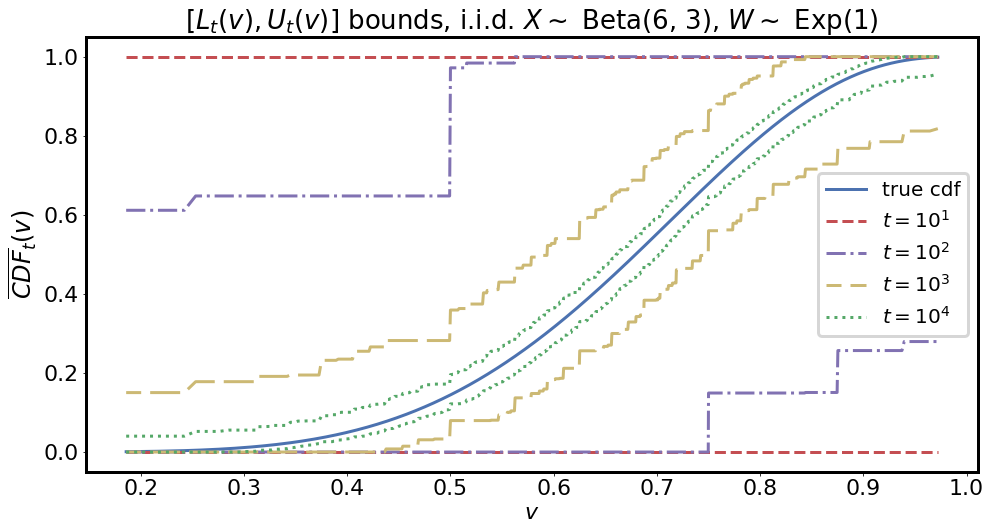

In [11]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 6, 3
    T = 10000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    ws = rng.exponential(scale=1, size=T)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab}), $W \\sim $ Exp(1)',
                cdf = lambda slf, x: betainc(betaa, betab, x)
               )
        
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
        
    plotit(data, ws, true, ref, 
           extra=[10, 100, 1000], 
           titles=[None, 
                   f'Bound width at $t={T}$',
                   f'$[L_t(v), U_t(v)]$ bounds, {true.desc}'],
           files=[None, 'betaexpiwboundwidthbern.pdf', 'betaexpiwcurvesbern.pdf'],
           compare=[
                    # Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab*mult}), $W \\sim $ Exp(1)',
                    #      data = rng.beta(betaa, betab*mult, size=T)
                    #     )
                    # for mult in (100, 10000,)
                   ],
           hacks=[None, lambda fig, ax: ax.set_xscale('log'), None ],
          )

flass()

### Beta(6,3) reward distribution, Pareto(3/2) weight distribution
Using the uniform$([0,1])$ distribution as reference (reward) measure.  The importance weights have unbounded variance.

ubcdfy calc time: 2.41


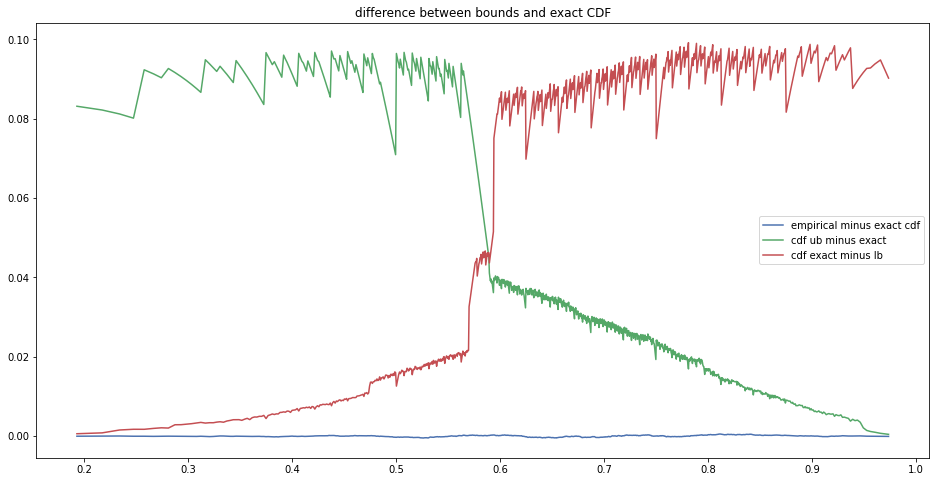

<Figure size 432x288 with 0 Axes>

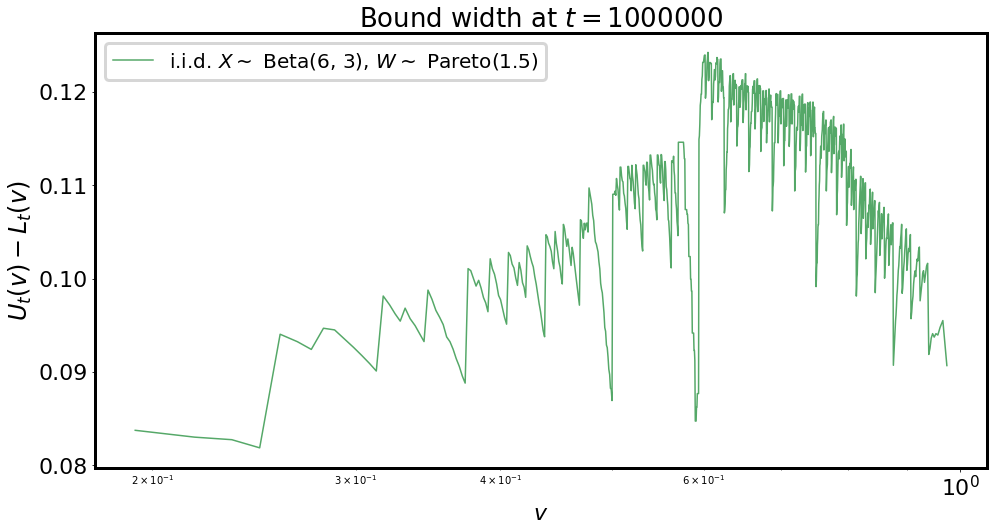

<Figure size 432x288 with 0 Axes>

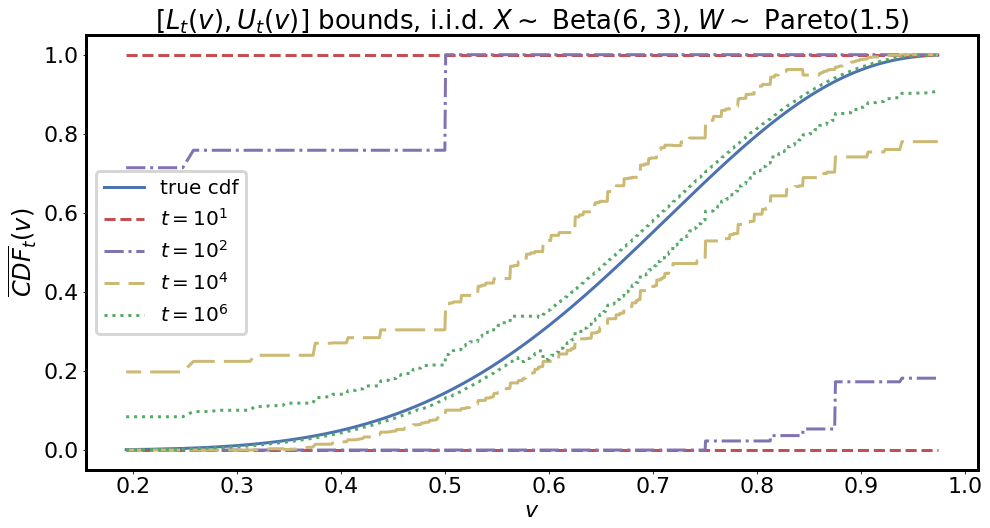

In [10]:
def flass(seed=4546):
    from scipy.special import betainc
    from numpy.random import default_rng

    betaa, betab = 6, 3
    paretoa = 3/2
    T = 1000000
    
    rng = default_rng(seed)
    data = rng.beta(betaa, betab, size=T)
    m = (paretoa - 1) / paretoa
    ws = (1 + rng.pareto(a=paretoa, size=T)) * m
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    true = Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab}), $W \\sim $ Pareto({paretoa})',
                cdf = lambda slf, x: betainc(betaa, betab, x)
               )
        
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
        
    plotit(data, ws, true, ref, 
           extra=[10, 100, 10000, ], 
           titles=[None, 
                   f'Bound width at $t={T}$',
                   f'$[L_t(v), U_t(v)]$ bounds, {true.desc}'],
           files=[None, 'betaparetoiwboundwidthbern.pdf', 'betaparetoiwcurvesbern.pdf'],
           compare=[
                    # Anon(desc = f'i.i.d. $X \\sim$ Beta({betaa}, {betab*mult}), $W \\sim $ Pareto({paretoa})',
                    #      data = rng.beta(betaa, betab*mult, size=T)
                    #     )
                    # for mult in (100, 10000,)
                   ],
           hacks=[None, lambda fig, ax: ax.set_xscale('log'), None ],
          )

flass()

# Nonstationary Example

## Multiple Continuous Polya Urn
See [csnsquantile](csnsquantile) for more intuition about the Continuous Polya Urn.

In this simulation the importance weights $W_t$ are drawn iid from a discrete distribution over $(0, w_{\max})$, which is inspired by $\epsilon$-greedy off-policy
evaluation in contextual bandits.  Given $W_t$, the distribution of $X_t$ is given by
$$
\begin{aligned}
X_t | W_t &\sim \text{Beta}\left(2 + \gamma_t \sum_{s < t} 1_{X_s > 1/2} 1_{W_s = W_t}, 2 + \gamma_t \sum_{s < t} 1_{X_s < 1/2} 1_{W_s = W_t}\right),
\end{aligned}
$$
i.e., each importance weight runs an independent continuous Polya Urn.  Because of this, it is possible for the on-policy (non-importance-weighted) CDF to mostly concentrate at 
one limit (e.g., 0) but the off-policy (importance-weighted) CDF to mostly concentrate at another limit (e.g., 1).

[(0, 0.75), (4, 0.25)]
(3.12, 25.57)
[(77.24, 2.06, 0.75, 0), (3.12, 25.57, 0.25, 4)]
defaultdict(<class 'float'>, {0: 7524.0, 4: 112.0}) defaultdict(<class 'float'>, {0: 6.0, 4: 2358.0})
ubcdfy calc time: 0.298


<Figure size 432x288 with 0 Axes>

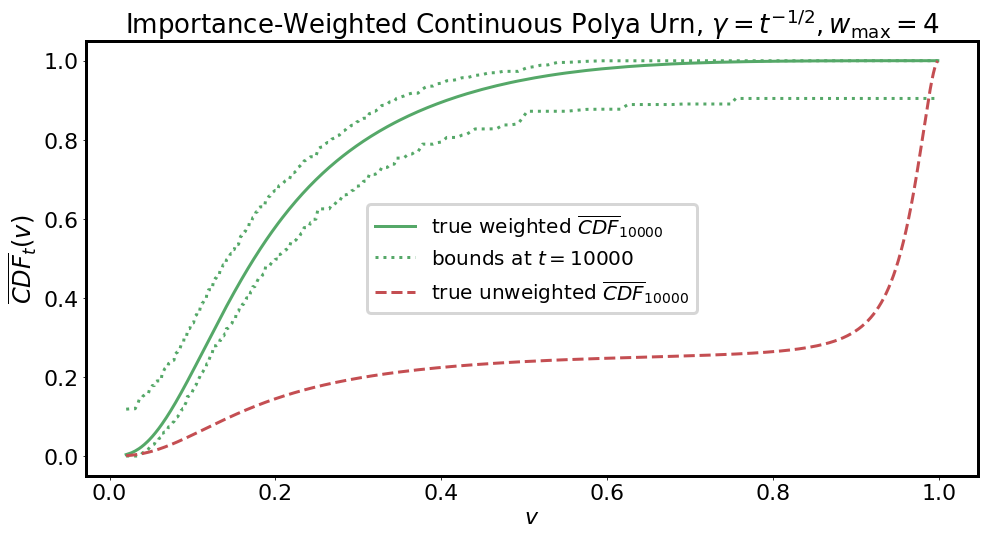

In [38]:
def megaplotit(datasets, weightsets, trues, ref, title=None, hack=None, file=None):
    from math import sqrt, log, pi
    from scipy.interpolate import interp1d
    import matplotlib.pyplot as plt
    import numpy as np
    import time
    
    linestyle_tuple = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('dashed', 'dashed'),    # Same as '--'
        ('dashdot', 'dashdot'),  # Same as '-.'
        #('loosely dotted',        (0, (1, 10))),
        #('dotted',                (0, (1, 1))),
        #('densely dotted',        (0, (1, 1))),
        ('long dash with offset', (5, (10, 3))),
        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ]
    megalw = 3
    megafs = 20
    
    conf = 0.05
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    ax.tick_params(labelsize=megafs+2)
    plt.style.use('seaborn-deep')
    
    for n, (data, weights, true) in enumerate(zip(datasets, weightsets, trues)):
        T = len(data)    
        nxvals = 1000
        ecdfx = np.sort(data)
        ecdfy = np.arange(1, len(data)+1)/float(len(data))
        probevals = np.interp(x=np.linspace(0.001, 0.999, nxvals), xp=ecdfy, fp=ecdfx, left=0, right=1)
        exactcdfy = np.array([ true.cdf(x) for x in probevals ])
        exactoffpolcdfy = np.array([ true.offpolcdf(x) for x in probevals ])
        
        counts = StreamingEmpBernECDF()
        for r, w in zip(data, weights):
            counts.addobs(r, w)
        icey = counts.freeze()
        lbcdfy = np.array([ getGenericLowerBound(x, counts = icey, conf = conf / 2, refcdf = ref.cdf, refppf = ref.ppf) for x in probevals ])
        start = time.time()
        ubcdfy = np.array([ getGenericUpperBound(x, counts = icey, conf = conf / 2, refsf = ref.sf, refisf = ref.isf) for x in probevals ])
        end = time.time()
        print(f'ubcdfy calc time: {end-start:.3g}')
        
        plt.plot(probevals, exactoffpolcdfy, label=f'true weighted $\\overline{{CDF}}_{{{T}}}${true.desc}', color=f'C{3*n+1}', linestyle=linestyle_tuple[3*n][1], linewidth=megalw)
        plt.plot(probevals, lbcdfy, label=f'bounds at $t={T}${true.desc}', color=f'C{3*n+1}', linestyle=linestyle_tuple[3*n+1][1], linewidth=megalw)
        plt.plot(probevals, ubcdfy, label=None, color=f'C{3*n+1}', linestyle=linestyle_tuple[3*n+1][1], linewidth=megalw)
        plt.plot(probevals, exactcdfy, label=f'true unweighted $\\overline{{CDF}}_{{{T}}}${true.desc}', color=f'C{3*n+2}', linestyle=linestyle_tuple[3*n+2][1], linewidth=megalw)
        
    ax.set_xlabel(f'$v$', fontsize=megafs+2)
    ax.set_ylabel('$\\overline{CDF}_t(v)$', fontsize=megafs+4)
    ax.legend(fontsize=megafs).get_frame().set_linewidth(megalw)
    for x in ax.spines.values():
        x.set_linewidth(megalw)
    plt.title(title or f'wazzup', fontsize=megafs+6)
    if hack:
        hack(fig, ax)
    if file:
        plt.savefig(file, bbox_inches='tight')

def flass():
    from collections import defaultdict
    from math import log
    from scipy.special import betainc, logsumexp
    import numpy as np
    from numpy.random import default_rng
    from fractions import Fraction
    
    class EpsilonGreedyIsh(object):
        def __init__(self, wmax, rng):
            super().__init__()
            assert wmax > 1, wmax
            
            # probs when E[w^2] = wmax
            self.p = ( (wmax - 1) / wmax,
                       1 / wmax,
                     )
            self.outcomes = (0, wmax)
            self.rng = rng
            
        def sample(self, size=None):
            return self.rng.choice(a=self.outcomes, p=self.p, size=size)
    
    def logbetapdf(a, b, p):
        from math import log1p
        from scipy.special import betaln
                
        return (b - 1) * log1p(-p) + (a - 1) * log(p) - betaln(a, b)
    
    Anon = lambda **kwargs: type("Object", (), kwargs)()
    
    T = 10000
    wmax = 4
    logT = log(T)
    
    datasets = []
    weightsets = []
    trues = []
    for limit, seed in enumerate((4550,)):
        rng = default_rng(seed)
        weightsampler = EpsilonGreedyIsh(wmax=wmax, rng=rng)
        print(list(zip(weightsampler.outcomes, weightsampler.p)))
        data = []
        weights = []
        betas = []
        megabetas = []
        sumxgthalf = defaultdict(float)
        sumxleqhalf = defaultdict(float)
        powt = -1/2
        for t in range(1, T+1):
            w = weightsampler.sample()
            betaa = 2 + (t**powt) * sumxgthalf[w] 
            betab = 2 + (t**powt) * sumxleqhalf[w]
            data.append(rng.beta(betaa, betab))
            weights.append(w)
            betas.append((betaa, betab))
            megabetas.append( [ (a, b, p, w)
                                for w, p in zip(weightsampler.outcomes, weightsampler.p)
                                for a in (2 + (t**powt) * sumxgthalf[w],)
                                for b in (2 + (t**powt) * sumxleqhalf[w],)
                              ] )
            (sumxgthalf if 2 * data[-1] > 1 else sumxleqhalf)[w] += 1
    
        print(f'{betas[-1]}')
        print(f'{megabetas[-1]}')
        print(f'{sumxgthalf} {sumxleqhalf}')
        data = np.array(data)        
    
        true = Anon(desc = f'',
                    cdf = (lambda z: (lambda slf, x: sum(p*betainc(a, b, x) for dist in z
                                                                            for (a, b, p, w) in dist)/T))(megabetas),
                    offpolcdf = (lambda z: (lambda slf, x: sum(p*w*betainc(a, b, x) for dist in z
                                                                                    for (a, b, p, w) in dist)/T))(megabetas),
                   )

        datasets.append(data)
        weightsets.append(weights)
        trues.append(true)
    
    ref = Anon(cdf = lambda slf, x: x,
               ppf = lambda slf, x: x,
               sf = lambda slf, x: 1 - x,
               isf = lambda slf, x: 1 - x,
              )
    
    megaplotit(datasets, weightsets, trues, ref, 
               title=f'Importance-Weighted Continuous Polya Urn, $\\gamma = t^{{{Fraction(powt)}}}, w_\max = {wmax}$',
               file='iwcontpolyatwoseeds.pdf')

# seed 4550 concentrates at 1
# seed 4548 concentrates at 0
flass()